In [1]:
import numpy as np
import math as m
from random import shuffle
from time import sleep
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import pandas as pd
import requests
from requests.structures import CaseInsensitiveDict
import openrouteservice as ors
import folium

In [2]:
# Variable Initialization
totalHouses = 25
houses = []
animationSpeed = 0
rankSize = 3
houseRank = {
            1 : [],
            2 : [],
            3 : []
            }
housesDist = dict()
xLim , yLim = [], [] # [77.4000,77.4100], [28.5600,28.5800]
file_to_charge = {
                 'Delhi' : 'Houses(Delhi).json',
                 'Chennai' : 'Houses(Chennai).json',
                 'Kolkata' : 'Houses(Kolkata).json'
                 }
locationName = 'Delhi' # Change this as per the location to consider
H_Dict = dict()

# GA variables
population, fitness = [],[]
popSize = 500
generationNumber = 0

recordDistance, currentRecord = m.inf,m.inf
bestEver, currentBest = [],[]
statusP = 0
mutationRate = 0.01

loopBreaker = 0

In [3]:
def getHouseFromDataBase():
    global file_to_charge, locationName, H_Dict
    
    url = 'https://raw.githubusercontent.com/AdrijeGuha/Travelling-Salesman-Problem/master/DataSet/'+file_to_charge[locationName]
    
    resp = requests.get(url)
    
    # Error checkinh and displaying the same
    statusCode = resp.status_code
    codes ={
            204 : 'Error Code 204 - No Content!',
            301 : 'Error Code 301 - Moved Permanently!',
            400 : 'Error Code 400 - Bad Request!',
            401 : 'Error Code 401 - Unauthorized!',
            403 : 'Error Code 403 - Forbidden!',
            404 : 'Error Code 404 - Not Found!',
            500 : 'Error Code 500 - Internal Server Error!'
           }
    if statusCode != 200:
        if statusCode in codes.keys():
             sys.exit(codes[statusCode]+' in getHouseFromDataBase()')
        else:
             sys.exit(f'Error Code {statusCode} in getHouseFromDataBase()')
    
    H_Dict = resp.json()

In [4]:
def DistanceMatrix():
    global totalHouses, houses, housesDist
    
    url = "https://api.geoapify.com/v1/routematrix?apiKey=6c8e353bd11c4807961ed51e8772fb43"
    headers = CaseInsensitiveDict()
    headers["Content-Type"] = "application/json"
    
    sources, LongLat = '[', ''
    for i in range(totalHouses):
        LongLat='{"location":['+str(houses[i][1])+','+str(houses[i][0])+']}'
        if i < totalHouses-1:
            LongLat +=','
        sources += LongLat
    sources += ']'

    targets = str(sources)
    data = '{"mode":"walk","sources":'+sources+',"targets":'+targets+'}'
    
    resp = requests.post(url, headers=headers, data=data)

    # Error checkinh and displaying the same
    statusCode = resp.status_code
    codes ={
            204 : 'Error Code 204 - No Content!',
            301 : 'Error Code 301 - Moved Permanently!',
            400 : 'Error Code 400 - Bad Request!',
            401 : 'Error Code 401 - Unauthorized!',
            403 : 'Error Code 403 - Forbidden!',
            404 : 'Error Code 404 - Not Found!',
            500 : 'Error Code 500 - Internal Server Error!'
           }
    if statusCode != 200:
        if statusCode in codes.keys():
             sys.exit(codes[statusCode]+' in DistanceMatrix()')
        else:
             sys.exit(f'Error Code {statusCode} in DistanceMatrix()')
                
    housesDist = resp.json()

In [15]:
def mapMaking():
    global houses, bestEver, xLim, yLim
    map_= folium.Map(location=[houses[bestEver[0]][1],houses[bestEver[0]][0]], zoom_start=15)

    folium.raster_layers.TileLayer('Open Street Map').add_to(map_)
    folium.raster_layers.TileLayer('CartoDB Dark_Matter').add_to(map_)
    
    client = ors.Client(key='5b3ce3597851110001cf6248056e10b584294591af7668d77907c079')

    for i in range(len(bestEver)-1):
        c = [[houses[bestEver[i]][1],houses[bestEver[i]][0]],[houses[bestEver[i+1]][1],houses[bestEver[i+1]][0]]]
        mapping = client.directions(coordinates=c, profile='driving-car', format='geojson')
        folium.GeoJson(mapping, name=f'House {houses[bestEver[i]][2]}').add_to(map_)
        sleep(2)
    
    for i in range(len(bestEver)):
        folium.Marker([houses[bestEver[i]][0], houses[bestEver[i]][1]], popup=f'House {houses[bestEver[i]][2]}', icon=folium.Icon(color='red'),tooltip='click').add_to(map_)

    folium.LayerControl(position='topright',collapsed=True).add_to(map_)
    map_.save("output_folder/House_Route_On_Map.html")
    return(map_)

In [6]:
def setGraphLimits():
    global houses, xLim , yLim
    
    xLim =[min(houses, key=lambda x: x[1])[1]-0.001, max(houses, key=lambda x: x[1])[1]+0.001]
    yLim =[min(houses, key=lambda x: x[0])[0]-0.001, max(houses, key=lambda x: x[0])[0]+0.001]

In [7]:
#Genetic Algorithm
def calculateFitness():
    global houses, popSize, populatuion, recordDistance, bestEver, currentRecord, currentBest, fitness
    
    currentRecord = m.inf
    for i in range(popSize):
        d = calcDistance(population[i])
        if d < recordDistance:
            recordDistance = d
            bestEver = population[i]
        if d < currentRecord:
            currentRecord = d
            currentBest = population[i]
        fitness.append(1 / (m.pow(d, 8) + 1))

def normalizeFitness():
    _sum = sum(fitness)
    for i in range(len(fitness)):
        fitness[i] = fitness[i] / _sum

def nextGeneration():
    global population, mutationRate, generationNumber
    
    newPopulation = []
    orderA, orderB, order = [], [], []
    for i in range(len(population)):
        orderA = pickOne(population , fitness)
        orderB = pickOne(population , fitness)
        order = crossOver(orderA, orderB)
        mutate(order)
        newPopulation.append(order)
    population = list(newPopulation)
    del(newPopulation)
    generationNumber += 1

def pickOne(lst, prob):
    index = 0
    r = np.random.rand(1)[0]
    while r>0:
        r = r - prob[index]
        index += 1
    index -= 1
    return list(lst[index])

def crossOver(orderA, orderB):
    start = np.random.randint(len(orderA)-1)
    end = np.random.randint(start+1, len(orderA))
    neworder = orderA[start:end]
    for i in range(len(orderB)):
        house = orderB[i]
        if house not in neworder:
            neworder.append(house)
    return neworder

def mutate(order):
    global mutationRate
    
    for i in range(totalHouses):
        if (np.random.rand(1)[0]) < mutationRate:
            indexA = np.random.randint(len(order))
            indexB = (indexA + 1) % totalHouses
            swap(order, indexA, indexB)
#Genetic Algorithm

In [8]:
def variableReset(mrt, pops, tHouses, rSize):
    global totalHouses, houses, animationSpeed, rankSize, housesDist, houseRank, population, fitness, popSize, generationNumber, recordDistance, currentRecord, bestEver, currentBest, statusP, mutationRate, loopBreaker
    
    totalHouses = tHouses
    houses = [] 
    animationSpeed = 0
    rankSize = rSize
    for i in range(1,rankSize+1):
        houseRank[i].clear()
    housesDist = dict()
    
    # GA variables
    population, fitness = [],[]
    popSize = pops
    generationNumber = 0

    recordDistance, currentRecord = m.inf,m.inf
    bestEver, currentBest = [],[]
    statusP = 0
    mutationRate = mrt
    loopBreaker = 0

def setup():
    global totalHouses, houses, rankSize, housesDist, houseRank, H_Dict, population, popSize, mutationRate
    
    variableReset(mutationRate, popSize, totalHouses, rankSize)
    order = []
    latitude, longitude, rank = 0,0,0
    
    getHouseFromDataBase()
    
    for i in range(totalHouses):
        # houses.append((np.random.randint(10, high=1000, size=2)).tolist())
        # print(f'Entry for house {i+1}')
        houses.append([H_Dict['house'][i]['latitude'], H_Dict['house'][i]['longitude']])
        houses[i].append(i+1)
        order.append(i)
        # rank = int(input("\tRank :"))
        rank = np.random.randint(1, high=4)

        if rank in houseRank.keys():
            houseRank[rank].append(i)
    
    for i in range(popSize):
        population.append(list(order))
        shuffle(population[i])
    
    DistanceMatrix()
    setGraphLimits()

def draw():
    global generationNumber 
    
    for i in range(popSize):
        genSort_Rank(i)
    
    calculateFitness()
    normalizeFitness()
    nextGeneration()
    
    graphingHouses()
    print(f'Generation: {generationNumber}')

def graphingHouses():
    global totalHouses, houses, recordDistance, xLim, yLim, bestEver, currentBest, currentRecord, animationSpeed
    
    xList, yList, _x, _y = [],[],[],[]
    plt.style.use('dark_background')
    plt.subplots(figsize=(20, 10))
    fig = plt.subplot(1,2,1)

    for i in bestEver: 
        x=houses[i][1]
        y=houses[i][0]
        _x.append(x)
        _y.append(y)
    # Plotting the graph of the shortest path
    plt.plot(_x,_y,'ro',ms='6')
    plt.plot(_x, _y, color='pink',ms='5')
    plt.title("All Time Best\nTotal distance = {0:.5f} units\nVisiting House sequence:{1}"
              .format(recordDistance,str([(i+1) for i in bestEver])))
    plt.ylim(yLim[0],yLim[1])
    plt.xlim(xLim[0],xLim[1])
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.grid(color='grey', linestyle='-', linewidth='0.25')
    for i,j in enumerate(bestEver):
        plt.annotate('house {}'.format(houses[j][2]),xy=(_x[i]-0.0001, _y[i]-0.0001), color='y', fontsize=10)


    fig = plt.subplot(1,2,2)
    for i in currentBest: 
        x=houses[i][1]
        y=houses[i][0]
        xList.append(x)
        yList.append(y)
        plt.plot(x,y,'ro',ms='5')
        plt.annotate('house {}'.format(houses[i][2]),xy=(x-0.0001, y-0.0001), color='y', fontsize=10)
    plt.style.use('dark_background')
    plt.ylim(yLim[0],yLim[1])
    plt.xlim(xLim[0],xLim[1])
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.grid(color='grey', linestyle='-', linewidth='0.25')
    plt.plot(xList, yList, color='white')
    plt.title("Generation Best\nTotal distance = {0:.5f} units\nVisiting House sequence:{1}"
              .format(currentRecord,str([(i+1) for i in currentBest])))    

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4 )
    plt.show() # Displaying all the ploted graph(s)
    sleep(animationSpeed) # Setting the animation speed of the output
        
def swap(a, i ,j):
    a[i], a[j] = a[j], a[i]

def calcDistance(order):
    global housesDist
    
    _sum = 0
    for i in range(len(order)-1):
        houseAindex = order[i]
        houseBindex = order[i+1]
        d = housesDist['sources_to_targets'][houseAindex][houseBindex]['distance']
        _sum += d
    return _sum

def genSort_Rank(orderNumber):
    def getKey(val):
        for key, value in houseRank.items():
            if val in value:
                return int(key)
        return 4
    
    for i in range(1,totalHouses):
        houseNumber,pos = population[orderNumber][i],i
        
        while (pos>0 and getKey(population[orderNumber][pos-1]) > getKey(houseNumber)):
            population[orderNumber][pos] = population[orderNumber][pos-1]
            pos-= 1
        population[orderNumber][pos] = houseNumber

In [9]:
setup()

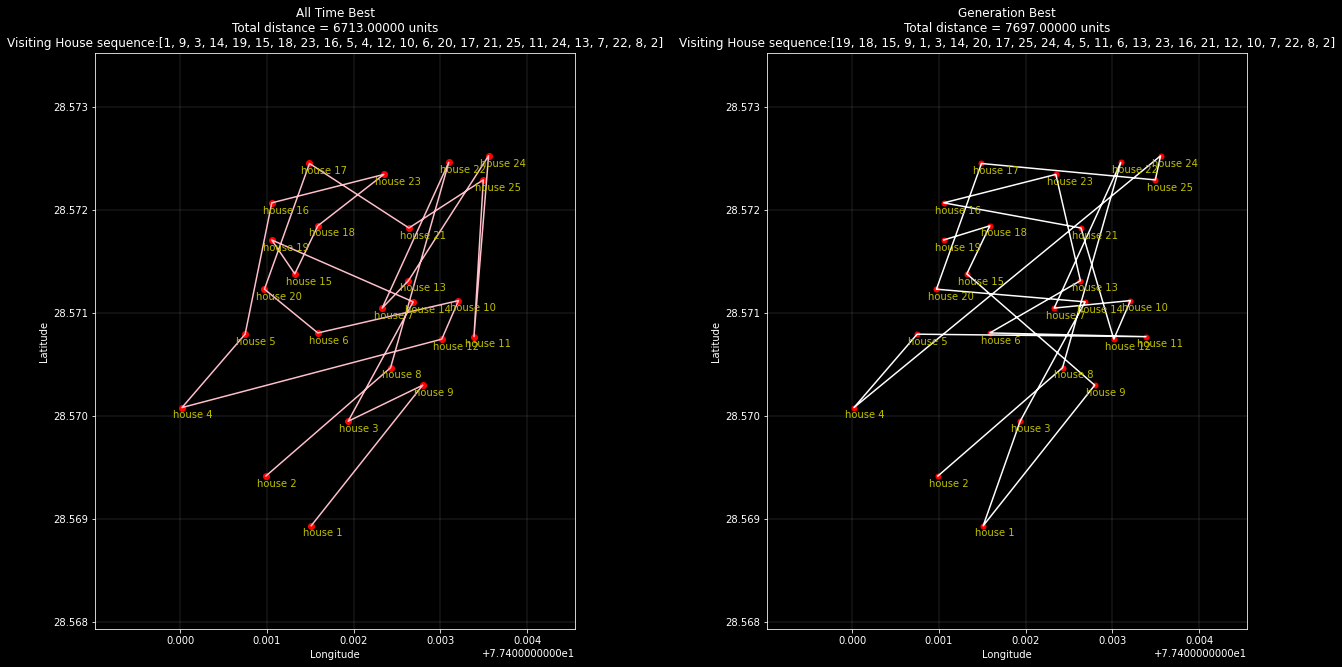

Generation: 300
Shortest visiting sequence of houses is [1, 9, 3, 14, 19, 15, 18, 23, 16, 5, 4, 12, 10, 6, 20, 17, 21, 25, 11, 24, 13, 7, 22, 8, 2], with total diatnace to cover 6713 units.
Program Completed successfully.


In [10]:
extension = 200
flg = True
while flg:
    draw()    
    if generationNumber >= extension:
        if loopBreaker == recordDistance:
            print(f"Shortest visiting sequence of houses is {[i+1 for i in bestEver]}, with total diatnace to cover {recordDistance} units.\nProgram Completed successfully.")
            flg = False
        else:
            loopBreaker = recordDistance
            extension += 100 ;
    clear_output(wait=True)

In [16]:
mapMaking()